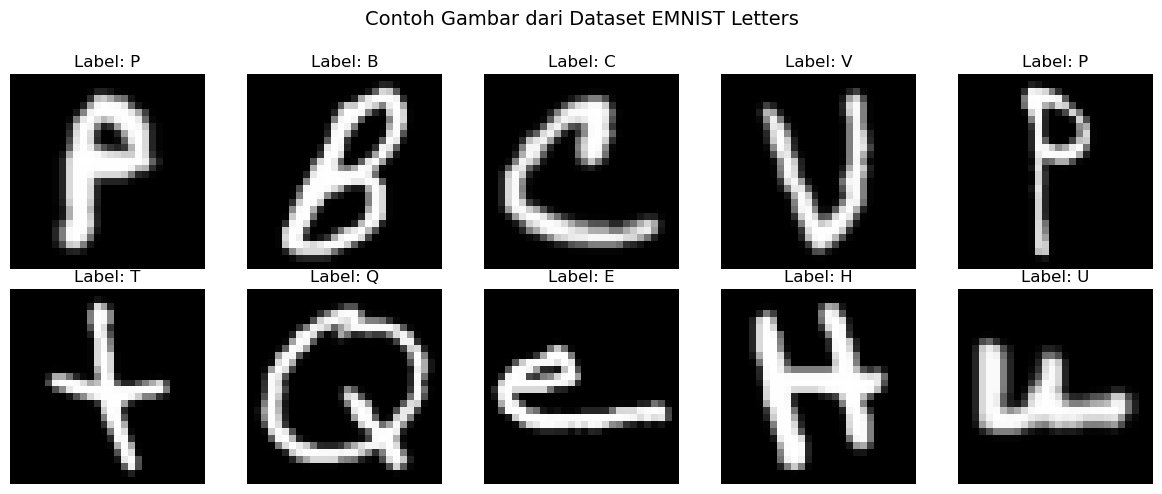

Proses LOOCV: 100%|██████████| 2600/2600 [28:13<00:00,  1.54it/s]  


Accuracy: 0.7588461538461538
Precision: 0.7641127612985484
F1-Score: 0.7592728075001653


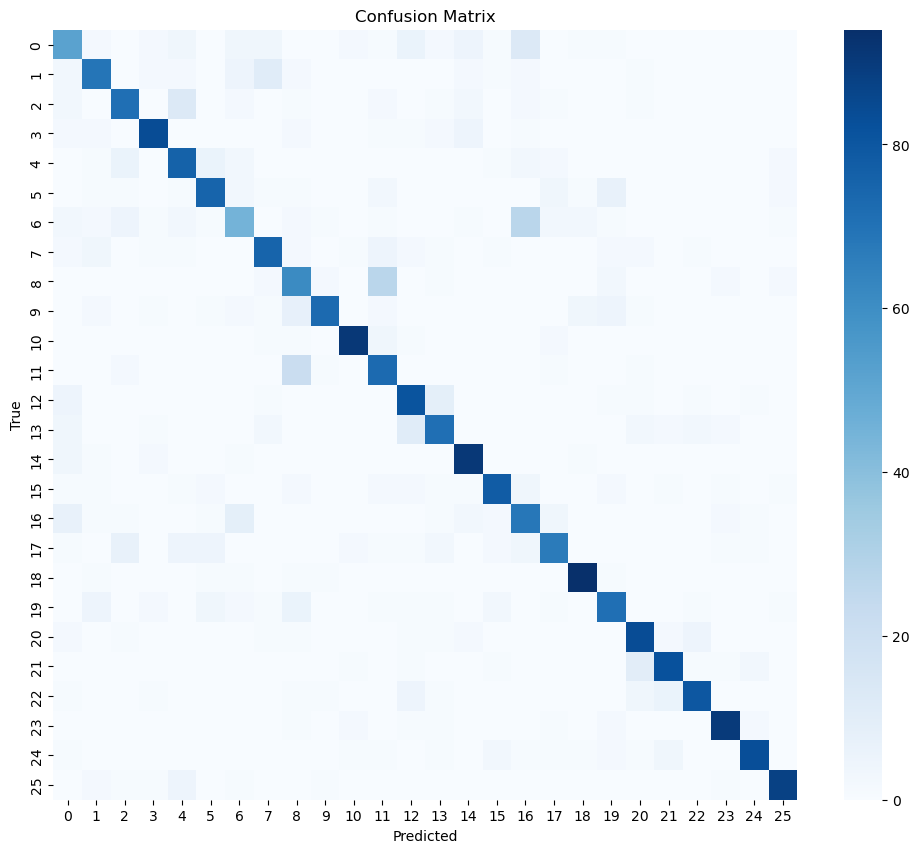

In [1]:
# EMNIST Letters Classification - Midterm RE604

# 1. Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from skimage.feature import hog
from tqdm import tqdm

# 2. Load Dataset (Pastikan file emnist-letters-train.csv ada di folder kerja)
df = pd.read_csv("emnist-letters-train.csv", header=None)

# 3. Sampling 100 samples per class (total 2600 data)
samples_per_class = 100
data = []
for label in range(1, 27):  # 1–26 untuk huruf A-Z
    class_samples = df[df[0] == label].sample(samples_per_class, random_state=42)
    data.append(class_samples)

balanced_df = pd.concat(data).sample(frac=1, random_state=42).reset_index(drop=True)

# 4. Prepare Image and Labels
images = balanced_df.iloc[:, 1:].values.reshape(-1, 28, 28)
labels = balanced_df.iloc[:, 0].values
images = np.transpose(images, (0, 2, 1))  # Rotate image agar orientasi benar

# 5. Visualisasi 10 Gambar Contoh
mapping = {i: chr(64 + i) for i in range(1, 27)}  # 1 -> A, 2 -> B, ..., 26 -> Z
char_labels = [mapping[l] for l in labels]

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Contoh Gambar dari Dataset EMNIST Letters", fontsize=14)
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"Label: {char_labels[i]}")
    ax.axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# 6. Ekstraksi Fitur HOG
hog_features = []
for img in tqdm(images, desc="Ekstraksi HOG"):
    fd = hog(img, orientations=9, pixels_per_cell=(8, 8),
             cells_per_block=(2, 2), block_norm='L2-Hys')
    hog_features.append(fd)
hog_features = np.array(hog_features)

# 7. Klasifikasi SVM + Evaluasi LOOCV
loo = LeaveOneOut()
y_true, y_pred = [], []

clf = SVC(kernel='rbf', C=10, gamma=0.01)

for train_index, test_index in tqdm(loo.split(hog_features), total=hog_features.shape[0], desc="Proses LOOCV"):
    X_train, X_test = hog_features[train_index], hog_features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    
    y_true.append(y_test[0])
    y_pred.append(pred[0])

# 8. Evaluasi Akhir
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", acc)
print("Precision:", prec)
print("F1-Score:", f1)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
